In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
from proj1_helpers import *
from implementations import *
import matplotlib.pyplot as plt

In [3]:
def cross_validation_visualization(lambds, mse_tr, mse_te):
    """visualization the curves of mse_tr and mse_te."""
    plt.semilogx(lambds, mse_tr, marker=".", color='b', label='train error')
    plt.semilogx(lambds, mse_te, marker=".", color='r', label='test error')
    plt.xlabel("lambda")
    plt.ylabel("rmse")
    plt.title("cross validation")
    plt.legend(loc=2)
    plt.grid(True)
    plt.savefig("cross_validation")

In [4]:
def extend_and_standardize(input_data, mean=None, std=None):
    if mean is not None and std is not None:
        mean_x = mean
        std_x = std
        tx = (input_data - mean) / std
        num_samples = input_data.shape[0]
        tx = np.c_[np.ones(num_samples), tx]
    else: 
        x, mean_x, std_x = standardize(input_data)
        tx = build_model_data(x)
    return tx, mean_x, std_x

In [5]:
def reconstruct_labels():
    raise NotImplemented

In [53]:
test = np.array([1,2,3,4])
b = np.array([True,False,True,False])
v = np.array([9,8])
test[b] = v

In [54]:
test

array([9, 2, 8, 4])

In [68]:
def model_output(tx, ws, pri_jet_num_idx, clean_features, parameters):
    cond_null = tx[:, pri_jet_num_idx] == 0
    cond_one = tx[:, pri_jet_num_idx] == 1
    cond_plural = tx[:, pri_jet_num_idx] >= 2
    conditions = (cond_null, cond_one, cond_plural)

    N = tx.shape[0]
    model_output = np.zeros(N)
    for pri_jet_num, cond in enumerate(conditions):
        select_features = clean_features[pri_jet_num]
        reduced_dset = tx[cond][:,select_features]
        mean, std = parameters[pri_jet_num]
        extended_dset,_,_ = extend_and_standardize(reduced_dset,mean,std)
        weight = ws[pri_jet_num]
        sub_output = extended_dset.dot(weight)
        model_output[cond] = sub_output
        
    return model_output

In [57]:
def compute_predictions(model_output):
    predictions = model_output
    predictions[predictions > 0.5] = 1
    predictions[predictions <= 0.5] = 0
    return predictions

In [58]:
def logistic_predictions(model_output):
    predictions = np.sign(model_output)
    predictions[predictions == -1] = 0
    return predictions

In [9]:
def compute_accuracy(y, predictions):
    N = y.size
    accuracy = 1 - (np.count_nonzero(predictions-y)/N)
    print("Accuracy: {}".format(accuracy))

# Part 1: Without feature engineering

### Import Dataset

In [42]:
train_data = 'all/train.csv'
labels, input_data, ids, features = load_csv_data(train_data)

In [43]:
features

array(['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis',
       'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot',
       'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta',
       'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi',
       'PRI_met', 'PRI_met_phi', 'PRI_met_sumet', 'PRI_jet_num',
       'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi',
       'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta',
       'PRI_jet_subleading_phi', 'PRI_jet_all_pt'], dtype='<U27')

In [44]:
i, = np.where(features == 'PRI_jet_num')
categorial_index = np.squeeze(i)
print(categorial_index)

22


In [45]:
tx = extend_and_standardize(input_data)

In [46]:
training_ratio = 0.8

In [47]:
x_tr, x_te, y_tr, y_te = split_data(input_data, labels, training_ratio)

## Gradient descent

In [86]:
initial_w = np.zeros(x_tr.shape[1])
max_iters = 100
gamma = 0.1

In [87]:
losses_GD, ws_GD = least_squares_GD(y_tr, x_tr, initial_w, max_iters, gamma)

Gradient Descent(0/99): loss=0.1710925, w0=-2.9427268665000046, w1=-1.0965389080000032
Gradient Descent(1/99): loss=9044196252.375938, w0=1067369.715524102, w1=-604250.9584981919
Gradient Descent(2/99): loss=2.96613578261203e+21, w0=676556181059.0527, w1=-343691735948.4086
Gradient Descent(3/99): loss=9.74751522294366e+32, w0=3.8974846366841414e+17, w1=-1.969887387915228e+17
Gradient Descent(4/99): loss=3.2033231238617575e+44, w0=2.2349952291066886e+23, w1=-1.1292573538441004e+23
Gradient Descent(5/99): loss=1.05270722272537e+56, w0=1.281269972346089e+29, w1=-6.47360668911357e+28
Gradient Descent(6/99): loss=3.459508936306597e+67, w0=7.345053266512663e+34, w1=-3.711075037454182e+34
Gradient Descent(7/99): loss=1.1368974983795755e+79, w0=4.210643285763422e+40, w1=-2.1274196330067505e+40
Gradient Descent(8/99): loss=3.736183214493115e+90, w0=2.413803341208911e+46, w1=-1.219569598973335e+46
Gradient Descent(9/99): loss=1.227820892574402e+102, w0=1.3837426010619725e+52, w1=-6.9913334617531

/home/julien/Documents/Epfl/Courses/ML_course/projects/project1/scripts/implementations.py:6: RuntimeWarning: overflow encountered in square
  return 1/2*np.mean(e**2)
/home/julien/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:70: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


Gradient Descent(47/99): loss=inf, w0=9.08836037519975e+270, w1=-4.591876982566845e+270
Gradient Descent(48/99): loss=inf, w0=5.210014914860252e+276, w1=-2.6323502346649437e+276
Gradient Descent(49/99): loss=inf, w0=2.986705444376741e+282, w1=-1.5090273071878761e+282
Gradient Descent(50/99): loss=inf, w0=1.7121658108936018e+288, w1=-8.650685550315859e+287
Gradient Descent(51/99): loss=inf, w0=9.815202130201088e+293, w1=-4.95911241194818e+293
Gradient Descent(52/99): loss=inf, w0=5.626685934490384e+299, w1=-2.8428724834924974e+299
Gradient Descent(53/99): loss=inf, w0=inf, w1=-inf
Gradient Descent(54/99): loss=nan, w0=nan, w1=nan
Gradient Descent(55/99): loss=nan, w0=nan, w1=nan
Gradient Descent(56/99): loss=nan, w0=nan, w1=nan
Gradient Descent(57/99): loss=nan, w0=nan, w1=nan
Gradient Descent(58/99): loss=nan, w0=nan, w1=nan
Gradient Descent(59/99): loss=nan, w0=nan, w1=nan
Gradient Descent(60/99): loss=nan, w0=nan, w1=nan
Gradient Descent(61/99): loss=nan, w0=nan, w1=nan
Gradient Desc

In [63]:
w_GD = ws_GD[-1]

In [64]:
ws_GD

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([ 2.94272687e-02,  1.09653891e-02,  2.75102620e-02,  2.56041405e-02,
        -2.11858017e-01, -1.45857418e-01, -2.12510540e-01,  8.16895690e-04,
         6.30458877e-03,  6.25701617e-02,  4.13644105e-04,  1.11273860e-04,
        -2.12175279e-01,  1.57377058e-02, -4.59088000e-06, -6.39518500e-06,
         1.56228530e-02, -6.00935500e-06,  1.88166500e-05,  1.45894218e-02,
         1.94715000e-06,  7.98476189e-02,  3.96995000e-04, -7.93485458e-02,
        -1.01669647e-01, -1.01670661e-01, -2.04880286e-01, -2.12253652e-01,
        -2.12255425e-01,  3.12096044e-02]),
 array([ 1.06796415e+02, -6.04029458e+01, -9.23697636e+01, -3.84355884e+01,
         1.12706000e+03,  1.13516483e+03,  1.12697427e+03, -2.85423127e+00,
        -1.67887619e+01, -1.18068634e+02, -1.58943812e+00,  5.15068626e-01,
         1.12702983e+03, -4.02580278e+01,  1.82093523e-02,

In [53]:
predictions_GD = compute_predictions(x_te,w_GD)
compute_accuracy(y_te,predictions_GD)

/home/julien/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/home/julien/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less_equal
  after removing the cwd from sys.path.


## Stochastic gradient descent

## Least squares

In [57]:
w_LS = least_squares(y_tr,x_tr)

In [60]:
w_LS

array([ 2.93423695e-05, -3.48912943e-03, -3.26343760e-03, -1.51679834e-04,
        1.21211206e-02,  2.12027995e-04, -9.48648403e-03,  1.85929094e-01,
       -1.27078510e-04, -2.83775188e+00, -1.02706124e-01,  4.86724095e-02,
        6.75712296e-03,  2.84230389e+00,  1.55100772e-04, -5.89131487e-04,
        2.84419968e+00,  4.10388756e-05,  3.85893837e-04,  1.79363132e-03,
       -2.06294585e-04, -2.17852008e-04,  2.12432765e-04,  9.49320717e-04,
       -5.80701064e-04, -3.12251922e-04,  1.39182472e-03, -4.00767000e-03,
       -7.01506316e-03,  2.83630071e+00])

In [58]:
predictions = compute_predictions(x_te,w_LS)

In [59]:
compute_accuracy(y_te,predictions)

Accuracy: 0.7453000000000001


## Ridge regression

### Use cross-validation to find good hyperparameter

In [92]:
seed = 1
k_fold = 4
k_indices = build_k_indices(y_tr, k_fold, seed)
lambda_ = 0.001

In [93]:
lambdas, tr_losses, te_losses = find_optimal_lambda(y_tr,x_tr)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29


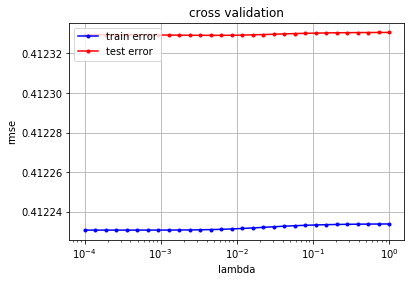

In [96]:
tr_losses = (2*np.array(tr_losses))**(0.5)
te_losses = (2*np.array(te_losses))**(0.5)
cross_validation_visualization(lambdas, tr_losses, te_losses)

In [70]:
optimal_lambda = find_optimal_lambda(y_tr,x_tr)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29


In [72]:
w_rr = ridge_regression(y_tr,x_tr,optimal_lambda)

In [88]:
optimal_lambda

0.004520353656360241

In [73]:
predictions = compute_predictions(x_te,w_rr)

In [75]:
compute_accuracy(y_te,predictions)

Accuracy: 0.7453000000000001


## Logistic regression

In [76]:
initial_w = np.zeros(x_tr.shape[1])
max_iters = 1000
gamma = 0.01

In [77]:
loss, w_logistic = logistic_regression(y_tr, x_tr, initial_w, max_iters, gamma)

/home/julien/Documents/Epfl/Courses/ML_course/projects/project1/scripts/implementations.py:194: RuntimeWarning: divide by zero encountered in log
  # start the logistic regression
/home/julien/Documents/Epfl/Courses/ML_course/projects/project1/scripts/implementations.py:194: RuntimeWarning: invalid value encountered in multiply
  # start the logistic regression


Current iteration=0, loss=nan
Current iteration=100, loss=nan
Current iteration=200, loss=nan
Current iteration=300, loss=nan
Current iteration=400, loss=nan
Current iteration=500, loss=nan
Current iteration=600, loss=nan
Current iteration=700, loss=nan
Current iteration=800, loss=nan
Current iteration=900, loss=nan


In [80]:
predictions = logistic_predictions(x_te,w_logistic)
compute_accuracy(y_te,predictions)

Accuracy: 0.6876599999999999


## Regularized logistic regression

In [82]:
loss, w_reg_logistic = reg_logistic_regression(y_tr, x_tr, optimal_lambda, initial_w, max_iters, gamma)

/home/julien/Documents/Epfl/Courses/ML_course/projects/project1/scripts/implementations.py:194: RuntimeWarning: divide by zero encountered in log
  loss = (-y * np.log(pred) - (1 - y) * np.log(1 - pred)).mean()
/home/julien/Documents/Epfl/Courses/ML_course/projects/project1/scripts/implementations.py:194: RuntimeWarning: invalid value encountered in multiply
  loss = (-y * np.log(pred) - (1 - y) * np.log(1 - pred)).mean()


Current iteration=0, loss=nan
Current iteration=100, loss=nan
Current iteration=200, loss=nan
Current iteration=300, loss=nan
Current iteration=400, loss=nan
Current iteration=500, loss=nan
Current iteration=600, loss=nan
Current iteration=700, loss=nan
Current iteration=800, loss=nan
Current iteration=900, loss=nan


In [83]:
predictions = logistic_predictions(x_te,w_reg_logistic)
compute_accuracy(y_te,predictions)

Accuracy: 0.6372800000000001


# Part 2: EDA and feature engineering

### Import Dataset

In [10]:
train_data = 'all/train.csv'
labels, input_data, ids, features = load_csv_data(train_data)

In [11]:
training_ratio = 0.8

In [12]:
x_tr, x_te, y_tr, y_te = split_data(input_data, labels, training_ratio)

In [25]:
X, y = x_tr, y_tr

i, = np.where(features == 'PRI_jet_num')
pri_jet_num_idx = np.squeeze(i)
cond_null = X[:, pri_jet_num_idx] == 0
cond_one = X[:, pri_jet_num_idx] == 1
cond_plural = X[:, pri_jet_num_idx] >= 2
conditions = (cond_null, cond_one, cond_plural)

dsets = [X[cond] for cond in conditions]
ybs = [y[cond] for cond in conditions]

For now, just remove any column with undefined -999 values. Also, before standardization, remove features with 0 variance.

In [44]:
clean_dsets = []
clean_features = []

for dset in dsets:
    
    no_undefined = np.all(dset != -999, axis = 0)
    no_constant = np.any(dset != dset[0], axis = 0)
    cleaned = no_undefined * no_constant
    clean_dset = dset[:,cleaned]
    clean_dsets.append(clean_dset)
    clean_features.append(cleaned)

Standardize and extend data, save mean and standard deviation of each dataset.

In [46]:
parameters = []
standardized_dsets = []

for clean_dset in clean_dsets:
    standardized_dset, mean_x, std_x = extend_and_standardize(clean_dset)
    standardized_dsets.append(standardized_dset)
    parameters.append((mean_x,std_x))

Figure out what to do with ones (first standardize test data, then extend?)

## Gradient descent

In [108]:
ws_GD = []

In [109]:
for jet_num, standardized_dset in enumerate(standardized_dsets):
    initial_w = np.zeros(standardized_dset.shape[1])
    max_iters = 100
    gamma = 0.1
    losses_GD, w_GD = gradient_descent(ybs[jet_num], standardized_dset, initial_w, max_iters, gamma)
    ws_GD.append(w_GD[-1])

In [111]:
ws_GD

[array([ 0.25466336, -0.11403234, -0.15688081, -0.00620645,  0.13946813,
        -0.00620646,  0.06371787, -0.04719324,  0.01821125,  0.07977007,
        -0.00106369, -0.00070027,  0.01994717,  0.00398986, -0.00036993,
         0.01794179, -0.00300839,  0.01236306]),
 array([ 0.35715757, -0.10708843, -0.09449802, -0.02341071,  0.10282553,
         0.02734924,  0.05075708, -0.05454202,  0.07429119,  0.08354031,
         0.00200652, -0.00195198,  0.06944835, -0.00349758,  0.00086124,
         0.0280134 ,  0.00100633, -0.01606204,  0.00092031, -0.00141064,
        -0.0003619 ,  0.00092034]),
 array([ 0.44659008, -0.07889095, -0.04561531,  0.05543639,  0.01554164,
         0.08750075,  0.00440682,  0.08215008, -0.01007812,  0.01272572,
        -0.05299049,  0.06784521,  0.07128219,  0.07745927, -0.00132336,
        -0.00084767,  0.07609405, -0.00348365,  0.00172073,  0.03432116,
         0.00341711, -0.06809217, -0.04310871, -0.03954695,  0.00205765,
         0.00188416,  0.02398792,  0.00

In [112]:
output_GD = model_output(x_te, ws_GD, pri_jet_num_idx, clean_features, parameters)

In [114]:
predictions = compute_predictions(output_GD)

In [115]:
compute_accuracy(y_te,predictions)

Accuracy: 0.75754


## Stochastic Gradient descent

## Least squares

In [86]:
ws_LS = []

In [87]:
for jet_num, standardized_dset in enumerate(standardized_dsets):
    w_LS = least_squares(ybs[jet_num],standardized_dset)
    ws_LS.append(w_LS)

In [88]:
output_LS = model_output(x_te, ws_LS, pri_jet_num_idx, clean_features, parameters)

In [89]:
predictions = compute_predictions(output_LS)

In [90]:
compute_accuracy(y_te,predictions)

Accuracy: 0.75932


## Ridge regression

## Logistic regression

In [74]:
ws_LR = []

In [75]:
for jet_num, standardized_dset in enumerate(standardized_dsets):
    initial_w = np.zeros(standardized_dset.shape[1])
    max_iters = 1000
    gamma = 0.01
    loss, w_LR = logistic_regression(ybs[jet_num], standardized_dset, initial_w, max_iters, gamma)
    ws_LR.append(w_LR)

Current iteration=0, loss=0.6915266741929514
Current iteration=100, loss=0.5847499050193897
Current iteration=200, loss=0.5335542176109676
Current iteration=300, loss=0.5039049627987183
Current iteration=400, loss=0.4847225518812757
Current iteration=500, loss=0.47145646353599313
Current iteration=600, loss=0.4618642812218381
Current iteration=700, loss=0.4546944209020816
Current iteration=800, loss=0.44918830256916986
Current iteration=900, loss=0.44485990346899895
Current iteration=0, loss=0.6921043390462521
Current iteration=100, loss=0.6310089659073544
Current iteration=200, loss=0.6047626273202644
Current iteration=300, loss=0.5901113857226763
Current iteration=400, loss=0.5809115692353688
Current iteration=500, loss=0.5747081355348898
Current iteration=600, loss=0.570304369331443
Current iteration=700, loss=0.5670466314014861
Current iteration=800, loss=0.5645506208761831
Current iteration=900, loss=0.5625783209085244
Current iteration=0, loss=0.6914562497951404
Current iteration

In [76]:
output_LR = model_output(x_te, ws_LR, pri_jet_num_idx, clean_features, parameters)

In [81]:
predictions = logistic_predictions(output_LR)

In [82]:
compute_accuracy(y_te,predictions)

Accuracy: 0.75362


In [83]:
ws_LS

[array([ 2.54670120e-01, -1.29791051e-01, -2.06713965e-01,  5.41994422e+02,
         1.80205237e-01, -5.42018136e+02, -3.76513510e+01, -8.48740749e-02,
         1.62683385e-02,  2.43534917e+01, -8.68120412e-04, -4.31043964e-04,
         2.33937383e+01,  3.83319266e-03, -4.76985586e-04,  4.94183739e-02,
        -3.03036843e-03,  1.64220846e-02]),
 array([ 3.57167057e-01, -1.12698686e-01, -1.25749810e-01, -3.72885413e-02,
         1.24869101e-01,  2.76331699e-02, -3.00734360e+02, -8.18576648e-02,
         7.29655384e-02,  9.74707144e+01,  2.15696385e-03, -1.71870206e-03,
         1.00042365e+02, -3.47912423e-03,  9.03295074e-04,  3.67528519e-02,
         9.95462984e-04, -1.97688117e-02, -1.72895544e+03, -1.31083634e-03,
        -3.81814196e-04,  1.93678382e+03]),
 array([ 4.46601942e-01, -7.79887965e-02, -7.84996500e-02,  7.14226179e-02,
        -4.69495155e-03,  1.07923034e-01,  7.17063994e-03,  1.17025566e-01,
        -9.95257609e-03, -1.20891160e+02, -8.71715489e-02,  6.62158292e-02,


In [84]:
ws_LR

[array([-1.06508255, -0.45119356, -0.21199313, -0.03595331,  0.29905659,
        -0.03595332,  0.15784936, -0.29798676,  0.12536019,  0.3155822 ,
        -0.00140518, -0.00415845, -0.07345946,  0.01703571,  0.00186719,
        -0.22621891, -0.01126403,  0.08581374]),
 array([-5.88681443e-01, -4.18555938e-01, -1.09752612e-01,  2.88555303e-02,
         2.60236753e-01,  9.17481911e-02,  1.28123028e-01, -2.07077520e-01,
         3.24420954e-01,  2.59683834e-01,  3.11862629e-03, -1.18188949e-02,
         2.16878347e-02, -1.40054880e-02,  3.95079151e-03, -3.45611948e-02,
         5.27341240e-03,  2.29069799e-02,  5.33176476e-02, -6.22587356e-03,
        -4.50925292e-04,  5.33176835e-02]),
 array([-0.21953986, -0.33926629,  0.00072089,  0.20529115,  0.17305107,
         0.29032011, -0.11119544,  0.13171476, -0.13120939, -0.00159301,
        -0.15334595,  0.320811  ,  0.27236755,  0.24750596, -0.00959139,
        -0.00425963,  0.09248357, -0.01408606,  0.00742005,  0.08697769,
         0.01693

## Regularized logistic regression